RQ3 - How do Dockerfiles co-evolve with other source code?
==============

# Dependencies and Configurations

## Import Dependencies

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import itertools
from datetime import datetime
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib.ticker as ticker
import psycopg2
import os, gc
import re
from pandarallel import pandarallel
import warnings

## Database Configurations

In [2]:
POSTGRESQL_USER = os.getenv('POSTGRESQL_USER') if os.getenv('POSTGRESQL_USER') is not None else 'dockerstudy'
POSTGRESQL_PASSWORD = os.getenv('POSTGRESQL_PASSWORD') if os.getenv('POSTGRESQL_PASSWORD') is not None else 'dockerstudy'
POSTGRESQL_HOST_IP = os.getenv('POSTGRESQL_HOST_IP') if os.getenv('POSTGRESQL_HOST_IP') is not None else 'localhost'
POSTGRESQL_PORT = os.getenv('POSTGRESQL_PORT') if os.getenv('POSTGRESQL_PORT') is not None else '5432'
POSTGRESQL_DATABASE = os.getenv('POSTGRESQL_DATABASE') if os.getenv('POSTGRESQL_DATABASE') is not None else 'dockerstudy'

## Load the relevant tables

In [3]:
conn = psycopg2.connect(database=POSTGRESQL_DATABASE, user=POSTGRESQL_USER, password=POSTGRESQL_PASSWORD, host=POSTGRESQL_HOST_IP, port=POSTGRESQL_PORT)
Commits = pd.read_sql_query('''
select commit_id, commit_sha, repo_id, parents, repo_name, repo_location, stats_total, stats_additions, stats_deletions, changed_file_count, changed_files, author_committed_at, committer_committed_at
from public.commit
''', con = conn)
conn.close()

In [4]:
conn = psycopg2.connect(database=POSTGRESQL_DATABASE, user=POSTGRESQL_USER, password=POSTGRESQL_PASSWORD, host=POSTGRESQL_HOST_IP, port=POSTGRESQL_PORT)
Images = pd.read_sql_query('''
select image_name, source_repo_id, pull_count
from public.image
where source_repo_id is not null
''', con = conn)
conn.close()

In [5]:
conn = psycopg2.connect(database=POSTGRESQL_DATABASE, user=POSTGRESQL_USER, password=POSTGRESQL_PASSWORD, host=POSTGRESQL_HOST_IP, port=POSTGRESQL_PORT)
Dockerfiles_change_stats = pd.read_sql_query('''
select public.dockerfile.dockerfile_id, public.dockerfile.commit_sha, public.dockerfile.path, public.changedfile.status, public.changedfile.additions_count, public.changedfile.deletions_count, public.changedfile.changes_count, public.dockerfile.author_committed_at, public.dockerfile.committer_committed_at
from public.dockerfile, public.changedfile
where public.changedfile.commit_sha=public.dockerfile.commit_sha and public.changedfile.filename=public.dockerfile.path
''', con = conn)
conn.close()

In [6]:
conn = psycopg2.connect(database=POSTGRESQL_DATABASE, user=POSTGRESQL_USER, password=POSTGRESQL_PASSWORD, host=POSTGRESQL_HOST_IP, port=POSTGRESQL_PORT)
Dockerfiles = pd.read_sql_query('''
select dockerfile_id, image_name, path, commit_sha, repo_id, diff, author_committed_at, committer_committed_at
from public.dockerfile
''', con = conn)
conn.close()

In [7]:
Dockerfiles_change_stats = Dockerfiles_change_stats.drop_duplicates(subset=['commit_sha', 'path'])
Commits = Commits.drop_duplicates(subset=['commit_sha'])
changes_data = [Commits[Commits['commit_sha'].isin(Dockerfiles_change_stats['commit_sha'])].dropna()['stats_total'].values, Commits[~Commits['commit_sha'].isin(Dockerfiles_change_stats['commit_sha'])].dropna()['stats_total'].values]
additions_data = [Commits[Commits['commit_sha'].isin(Dockerfiles_change_stats['commit_sha'])].dropna()['stats_additions'].values, Commits[~Commits['commit_sha'].isin(Dockerfiles_change_stats['commit_sha'])].dropna()['stats_additions'].values]
deletions_data = [Commits[Commits['commit_sha'].isin(Dockerfiles_change_stats['commit_sha'])].dropna()['stats_deletions'].values, Commits[~Commits['commit_sha'].isin(Dockerfiles_change_stats['commit_sha'])].dropna()['stats_deletions'].values]

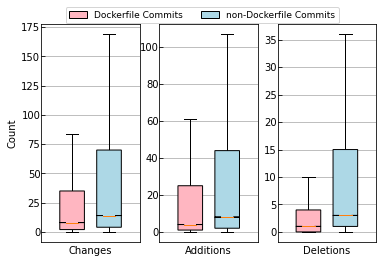

Median of Number of Changes in Dockerfile Commits:  8.0
Median of Number of Additions in Dockerfile Commits:  4.0
Median of Number of Deletions in Dockerfile Commits:  1.0
Median of Number of Changes in non-Dockerfile Commits:  14.0
Median of Number of Additions in non-Dockerfile Commits:  8.0
Median of Number of Deletions in non-Dockerfile Commits:  3.0


In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(6, 4))
position_list = list(range(0, 3))
bplot1 = ax1.boxplot(changes_data,
                         notch=True,
                         vert=True,
                         patch_artist=True,
                         showfliers=False,
                         positions= [-0.3, 0.3],
                         zorder=10,
                        widths=0.4)
bplot2 = ax2.boxplot(additions_data,
                         notch=True,
                         vert=True,
                         patch_artist=True,
                         showfliers=False,
                         positions= [0.7, 1.3],
                         zorder=10,
                        widths=0.4)
bplot3 = ax3.boxplot(deletions_data,
                         notch=True,
                         vert=True,
                         patch_artist=True,
                         showfliers=False,
                         positions= [1.7, 2.3],
                         zorder=10,
                        widths=0.4)
bplot1['boxes'][0].set_facecolor('lightpink')
bplot1['boxes'][1].set_facecolor('lightblue')
bplot2['boxes'][0].set_facecolor('lightpink')
bplot2['boxes'][1].set_facecolor('lightblue')
bplot3['boxes'][0].set_facecolor('lightpink')
bplot3['boxes'][1].set_facecolor('lightblue')
ax1.yaxis.grid(True)
ax2.yaxis.grid(True)
ax3.yaxis.grid(True)
ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])
ax1.tick_params(axis='y', direction ='in', pad=1)
ax2.tick_params(axis='y', direction ='in', pad=1)
ax3.tick_params(axis='y', direction ='in', pad=1)
ax_legend = ax3.legend([bplot1["boxes"][0], bplot1["boxes"][1]], ['Dockerfile Commits', 'non-Dockerfile Commits'], loc='upper left', bbox_to_anchor=(-2.2,1.1),  prop={'size': 9}, ncol=2)
ax1.set_xlabel('Changes')
ax2.set_xlabel('Additions')
ax3.set_xlabel('Deletions')
ax1.set_ylabel('Count')
plt.show()
fig.savefig('Changes_Additions_Deletions', dpi=300)
fig.savefig('Changes_Additions_Deletions.pdf')
print('Median of Number of Changes in Dockerfile Commits: ', np.median(changes_data[0]))
print('Median of Number of Additions in Dockerfile Commits: ', np.median(additions_data[0]))
print('Median of Number of Deletions in Dockerfile Commits: ', np.median(deletions_data[0]))
print('Median of Number of Changes in non-Dockerfile Commits: ', np.median(changes_data[1]))
print('Median of Number of Additions in non-Dockerfile Commits: ', np.median(additions_data[1]))
print('Median of Number of Deletions in non-Dockerfile Commits: ', np.median(deletions_data[1]))

In [9]:
conn = psycopg2.connect(database=POSTGRESQL_DATABASE, user=POSTGRESQL_USER, password=POSTGRESQL_PASSWORD, host=POSTGRESQL_HOST_IP, port=POSTGRESQL_PORT)
Commits = pd.read_sql_query('''
select commit_id, commit_sha, repo_id, parents, repo_name, repo_location, stats_total, stats_additions, stats_deletions, changed_file_count, changed_files, author_committed_at, committer_committed_at
from public.commit
''', con = conn)
conn.close()

In [10]:
Dockerfiles = Dockerfiles[['dockerfile_id', 'image_name', 'repo_id', 'path', 'commit_sha', 'committer_committed_at']]
image_and_path_with_gte2_commits = Dockerfiles.groupby(by=['image_name', 'path']).size()[Dockerfiles.groupby(by=['image_name', 'path']).size()>=2]
image_and_path_with_gte2_commits = pd.DataFrame(image_and_path_with_gte2_commits, columns=['commit_count'])
image_and_path_with_gte2_commits = image_and_path_with_gte2_commits.reset_index(inplace=False)
Dockerfiles_with_gte2_commits = Dockerfiles[Dockerfiles['image_name'].isin(image_and_path_with_gte2_commits['image_name']) & Dockerfiles['path'].isin(image_and_path_with_gte2_commits['path'])]
Dockerfiles_with_gte2_commits.index = range(0, Dockerfiles_with_gte2_commits.shape[0])
Dockerfiles_with_gte2_commits = Dockerfiles_with_gte2_commits[['dockerfile_id', 'image_name', 'repo_id', 'path', 'commit_sha', 'committer_committed_at']]

In [11]:
pandarallel.initialize()
Dockerfiles_with_gte2_commits = Dockerfiles_with_gte2_commits.groupby(['image_name', 'path']).parallel_apply(lambda x: x.sort_values(by='committer_committed_at', ascending=True))
commits_to_query = Commits[['repo_id', 'commit_sha']].copy()
commits_to_query['index'] = range(0, commits_to_query.shape[0])
commits_to_query = commits_to_query.set_index(keys=['repo_id', 'commit_sha'])

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [12]:
Dockerfiles_with_gte2_commits = Dockerfiles_with_gte2_commits.dropna()
Dockerfiles_with_gte2_commits.index = range(0, Dockerfiles_with_gte2_commits.shape[0])
Dockerfiles_with_gte2_commits['next_image_name'] = Dockerfiles_with_gte2_commits['image_name'].shift(-1)
Dockerfiles_with_gte2_commits['next_repo_id'] = Dockerfiles_with_gte2_commits['repo_id'].shift(-1)
Dockerfiles_with_gte2_commits['next_path'] = Dockerfiles_with_gte2_commits['path'].shift(-1)
Dockerfiles_with_gte2_commits['next_commit_sha'] = Dockerfiles_with_gte2_commits['commit_sha'].shift(-1)
Dockerfiles_with_gte2_commits['next_committer_committed_at'] = Dockerfiles_with_gte2_commits['committer_committed_at'].shift(-1)
Dockerfiles_with_gte2_commits['commit_window'] = pd.Series([], dtype=int)

In [13]:
def get_commit(previous_commit_sha, later_commit_sha, repo_id):
    try:
        later_row = commits_to_query['index'][(repo_id, later_commit_sha)]
        previous_row = commits_to_query['index'][(repo_id, previous_commit_sha)]
        return later_row - previous_row
    except:
        return None
def apply_get_commit(x):
    if x['image_name'] == x['next_image_name'] and x['path'] == x['next_path'] and x['repo_id'] == x['next_repo_id']:
        return get_commit(x['commit_sha'], x['next_commit_sha'], x['repo_id'])
warnings.filterwarnings("ignore")
pandarallel.initialize(nb_workers=32)
Dockerfiles_with_gte2_commits['commit_window'] = Dockerfiles_with_gte2_commits.parallel_apply(apply_get_commit, axis=1)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [14]:
Dockerfiles_with_gte2_commits = Dockerfiles_with_gte2_commits.dropna()
Dockerfiles_with_gte2_commits['commit_year'] = Dockerfiles_with_gte2_commits['committer_committed_at'].apply(lambda x: x.year)
Commits['commit_year'] = Commits['committer_committed_at'].apply(lambda x: x.year if x is not None else None)

In [15]:
ratio_results = {}
for year in range(2015, 2021):
    dockerfile_commit_count = Dockerfiles_with_gte2_commits.query("commit_year=={}".format(year)).groupby(by=['repo_id']).size()
    source_repo_commit_count = Commits.query("commit_year=={}".format(year)).groupby(by=['repo_id']).size()
    commit_ratio_to_query = pd.DataFrame()
    commit_ratio_to_query['repo_commit_count'] = source_repo_commit_count[dockerfile_commit_count.index[dockerfile_commit_count.index.isin(source_repo_commit_count.index) & dockerfile_commit_count.index.isin(Images[Images['pull_count']>=1000]['source_repo_id'])]]
    commit_ratio_to_query['dockerfile_commit_count'] = dockerfile_commit_count[dockerfile_commit_count.index[dockerfile_commit_count.index.isin(source_repo_commit_count.index) & dockerfile_commit_count.index.isin(Images[Images['pull_count']>=1000]['source_repo_id'])]]
    commit_ratio_to_query['ratio'] = commit_ratio_to_query.apply(lambda x: x['repo_commit_count']/x['dockerfile_commit_count'], axis=1)
    ratio_results[year] = commit_ratio_to_query['ratio'].values

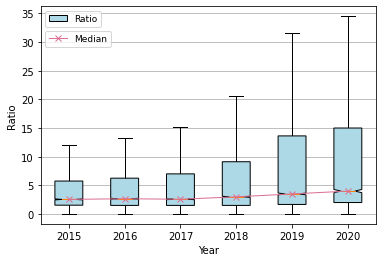

Median of the Ratio between the Source Repo Commit Count and Dockerfile Commit Count in 2015: 2.5454545454545454
Median of the Ratio between the Source Repo Commit Count and Dockerfile Commit Count in 2016: 2.6666666666666665
Median of the Ratio between the Source Repo Commit Count and Dockerfile Commit Count in 2017: 2.5714285714285716
Median of the Ratio between the Source Repo Commit Count and Dockerfile Commit Count in 2018: 3.0
Median of the Ratio between the Source Repo Commit Count and Dockerfile Commit Count in 2019: 3.5
Median of the Ratio between the Source Repo Commit Count and Dockerfile Commit Count in 2020: 4.0


In [16]:
ratio_in_year = [ratio_results[year] for year in list(range(2015, 2021))]
labels = list(range(2015, 2021))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
position_list = list(range(0, len(labels)))
bplot = ax.boxplot(ratio_in_year,
                         notch=True,
                         vert=True,
                         patch_artist=True,
                         showfliers=False,
                         positions=position_list,
                         labels=labels, zorder=10)

avg_cost_line = ax.plot(position_list,  [np.median(ratio_results[year]) for year in range(2015, 2021)], linewidth=1, color='palevioletred', marker='x', markeredgecolor='palevioletred', zorder=20, label='Median')

for patch in bplot['boxes']:
    patch.set_facecolor('lightblue')
    
ax.yaxis.grid(True)
ax_legend1 = ax.legend(loc='center left', bbox_to_anchor=(0,0.85),  prop={'size': 9})
ax_legend = ax.legend([bplot["boxes"][0]], ['Ratio'], loc='upper left', bbox_to_anchor=(0,1),  prop={'size': 9})
ax.add_artist(ax_legend1)
ax.set_xlabel('Year')
ax.set_ylabel('Ratio')
plt.show()
fig.tight_layout()
fig.savefig('Commit_Ratio', dpi=300)
fig.savefig('Commit_Ratio.pdf')
for year in range(2015, 2021):
    print('Median of the Ratio between the Source Repo Commit Count and Dockerfile Commit Count in {}: {}'.format(year, np.median(ratio_results[year])))